<a href="https://colab.research.google.com/github/erichsiao1106/gradcam/blob/master/Grad_CAM_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.applications import imagenet_utils
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
tf.__version__

'2.3.0'

In [ ]:
IMG_SIZE = 299

In [ ]:
model = tf.keras.applications.InceptionV3(include_top=True, 
                                          weights='imagenet')

96116736/96112376 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
def gradcam(model, img, layer_name='conv2d_93'):
    # get pred class idx
    preds = model.predict(img)
    pred_class_idx = np.argmax(preds[0])
    pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]

    # build a new model for Grad-CAM
    outputs = [model.get_layer(layer_name).output]
    outputs.append(model.output)

    
    with tf.GradientTape() as tape:
        conv_output, preds = model_gradcam(img)
        pred_output = preds[:, pred_class_idx]
        grads = tape.gradient(pred_output, conv_output)
        print('conv_output.shape', conv_output.shape)
        print('grads.shape', grads.shape)
    
    pooled_grads = tf.keras.backend.sum(grads, axis=(0, 1, 2)) # (2048, )
    print('pooled_grads.shape ', pooled_grads.shape)
    heatmap = pooled_grads * conv_output
    print('heatmaps.shape ', heatmap.shape)
    # heatmap = tf.keras.backend.mean(heatmap, axis=-1)[0, :, :, np.newaxis].numpy()
    heatmap = tf.keras.backend.mean(heatmap, axis=-1)[0, :, :].numpy()
    
    return heatmap, pred_class_name

In [ ]:
def processing_image(img_path):
    img = cv2.imread(img_path)[:,:,::-1]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img, axis=0)
    
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [ ]:
def plot_heatmap(heatmap, img_path):
    img = cv2.imread(img_path)[:,:,::-1]
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # normalization
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    # heatmap = np.float32(255 * heatmap)
    # show input img
    plt.figure(figsize=(10, 5))    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    # show heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img) # original img
    plt.imshow(heatmap, cmap='jet', alpha=0.6) # heatmap
    plt.show()

conv_output.shape (1, 8, 8, 192)
grads.shape (1, 8, 8, 192)
pooled_grads.shape  (192,)
heatmaps.shape  (1, 8, 8, 192)
pred_class_name:  Siberian_husky img_path:  /content/drive/My Drive/class/勞動部/week10/img/husky2.jpeg
heatmap.shape:  (8, 8)


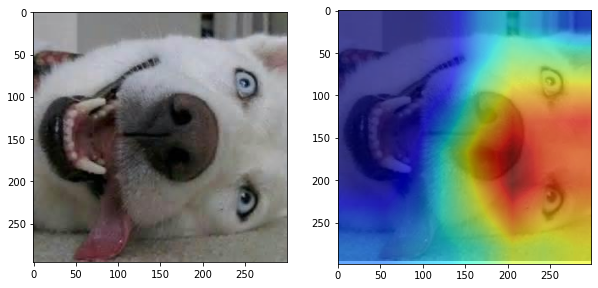

In [ ]:
i = random.choice(range(1,4))
i=2
img_path = f'/content/drive/My Drive/class/勞動部/week10/img/husky{i}.jpeg'
# img_path = f'/content/drive/My Drive/class/勞動部/week10/img/cock1.jpeg'
# img_path = f'/content/drive/My Drive/class/勞動部/week10/img/tennis.jpeg'

img = processing_image(img_path)
heatmap, pred_class_name = gradcam(model, img)
print('pred_class_name: ', pred_class_name, 'img_path: ', img_path)
print('heatmap.shape: ', heatmap.shape)
plot_heatmap(heatmap, img_path)